## Iowa Liquor Sales Predictions

Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import probplot
from scipy.stats.mstats import zscore
import statsmodels.stats.api as sms

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Let's read the data and make sure it displays all columns. None here means unlimited.So now when you do head, it shows all columns. Also, set the axes style and color pallete.

In [2]:
pd.set_option('max_columns',None)
sns.set(style='white',color_codes=True)
%matplotlib inline

In [3]:
liquor_data = pd.read_csv('Iowa_Liquor_Sales.csv', low_memory=False)
liquor_data.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,S29198800001,11/20/2015,2191,Keokuk Spirits,1013 MAIN,KEOKUK,52632,"1013 MAIN\nKEOKUK 52632\n(40.39978, -91.387531)",56.0,Lee,NaN,NaN,255.0,Wilson Daniels Ltd.,297,Templeton Rye w/Flask,6,750,18.09,27.14,6,162.84,4.50,1.19
1,S29195400002,11/21/2015,2205,Ding's Honk And Holler,900 E WASHINGTON,CLARINDA,51632,"900 E WASHINGTON\nCLARINDA 51632\n(40.739238, ...",73.0,Page,NaN,NaN,255.0,Wilson Daniels Ltd.,297,Templeton Rye w/Flask,6,750,18.09,27.14,12,325.68,9.00,2.38
2,S29050300001,11/16/2015,3549,Quicker Liquor Store,1414 48TH ST,FORT MADISON,52627,"1414 48TH ST\nFORT MADISON 52627\n(40.624226, ...",56.0,Lee,NaN,NaN,130.0,Disaronno International LLC,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,6.40,9.60,2,19.20,0.30,0.08
3,S28867700001,11/04/2015,2513,Hy-Vee Food Store #2 / Iowa City,812 S 1ST AVE,IOWA CITY,52240,812 S 1ST AVE\nIOWA CITY 52240\n,52.0,Johnson,NaN,NaN,65.0,Jim Beam Brands,237,Knob Creek w/ Crystal Decanter,3,1750,35.55,53.34,3,160.02,5.25,1.39
4,S29050800001,11/17/2015,3942,Twin Town Liquor,104 HIGHWAY 30 WEST,TOLEDO,52342,"104 HIGHWAY 30 WEST\nTOLEDO 52342\n(41.985887,...",86.0,Tama,NaN,NaN,130.0,Disaronno International LLC,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,6.40,9.60,2,19.20,0.30,0.08


We see some NaN values in our dataset.Deciding whether to drop the NaN data entries requires some analysis. Is there a pattern? Are they truly random? What is the percentage of NaN entries ina given column as compared to the valid entries? If we decide to drop them, what is the proportion of entries being dropped compared to the whole dataset, and will its omission materially affect our analysis?

Forunately in our case, the missing values make up only a very small percentage of our entire dataset as shown below. The nature of our data is such that a small amount of entries cannot have an outsize impact on the aggregate properties, and thus can be safely dropped.

### Data Wrangling

#### Understanding the data that is in our file

In [145]:
liquor_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14239562 entries, 6 to 14338591
Data columns (total 25 columns):
Invoice/Item Number      object
Date                     datetime64[ns]
Store Number             int64
Store Name               object
Address                  object
City                     object
Zip Code                 object
Store Location           object
County Number            float64
County                   object
Category                 float64
Category Name            object
Vendor Number            float64
Vendor Name              object
Item Number              int64
Item Description         object
Pack                     int64
Bottle Volume (ml)       int64
State Bottle Cost        float64
State Bottle Retail      float64
Bottles Sold             int64
Sale (Dollars)           float64
Volume Sold (Liters)     float64
Volume Sold (Gallons)    float64
Cost_dollars             float64
dtypes: datetime64[ns](1), float64(9), int64(5), object(10)
memory usage:

In [146]:
liquor_data.describe()

,Store Number,County Number,Category,Vendor Number,Item Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Cost_dollars
count,1.423956e+07,1.423956e+07,1.423956e+07,1.423956e+07,1.423956e+07,1.423956e+07,1.423956e+07,1.423956e+07,1.423956e+07,1.423956e+07,1.423956e+07,1.423956e+07,1.423956e+07,1.423956e+07
mean,3.592880e+03,5.723378e+01,1.044720e+06,2.579896e+02,4.606056e+04,1.225658e+01,9.268891e+02,9.707321e+00,1.458155e+01,7.412562e+00,1.120053e+02,6.812509e+00,1.798063e+00,6.477224e+01
std,9.548160e+02,2.728222e+01,5.524909e+04,1.412874e+02,5.300440e+04,7.510606e+00,7.118558e+02,1.121501e+01,1.682197e+01,2.093012e+01,3.620763e+02,2.527516e+01,6.677345e+00,2.412143e+02
min,2.106000e+03,1.000000e+00,1.011100e+06,1.000000e+01,1.010000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.605000e+03,3.100000e+01,1.012210e+06,1.150000e+02,2.704800e+04,6.000000e+00,7.500000e+02,5.500000e+00,8.250000e+00,2.000000e+00,2.296000e+01,1.200000e+00,3.200000e-01,1.290000e+01
50%,3.717000e+03,6.200000e+01,1.031200e+06,2.600000e+02,3.817600e+04,1.200000e+01,7.500000e+02,7.990000e+00,1.200000e+01,3.000000e+00,6.600000e+01,2.250000e+00,5.900000e-01,3.018000e+01
75%,4.344000e+03,7.700000e+01,1.062310e+06,3.800000e+02,6.413600e+04,1.200000e+01,1.000000e+03,1.180000e+01,1.770000e+01,1.200000e+01,1.319400e+02,9.000000e+00,2.380000e+00,6.894000e+01
max,9.938000e+03,9.900000e+01,1.901200e+06,9.870000e+02,9.992750e+05,6.000000e+02,3.780000e+05,7.680000e+03,1.152000e+04,1.500000e+04,2.541000e+05,1.500000e+04,3.962580e+03,1.695000e+05


In [147]:
print(liquor_data.shape)
liquor_data.dropna(how='any', axis = 0, inplace=True)
print(liquor_data.shape)

(14239562, 25)
(14239562, 25)


The method pandas.to_datetime() here helps us convert the string datatype of our Date column in the datetime64 datatype, thus making it amenable to later analysis.

In [148]:
liquor_data['Date'] = pd.to_datetime(liquor_data['Date'], infer_datetime_format=True)
dollar = ['State Bottle Cost','State Bottle Retail','Sale (Dollars)']
for col in dollar:
    liquor_data[col].replace("\$","", regex=True, inplace=True)
    liquor_data[col] = pd.to_numeric(liquor_data[col])
liquor_data.head(2)

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Cost_dollars
6,S28865700001,2015-11-09,2538,Hy-Vee Food Store #3 / Waterloo,1422 FLAMMANG DR,WATERLOO,50702,"1422 FLAMMANG DR\nWATERLOO 50702\n(42.459938, ...",7.0,Black Hawk,1701100.0,DECANTERS & SPECIALTY PACKAGES,962.0,Duggan's Distillers Products Corp,238,Forbidden Secret Coffee Pack,6,1500,11.62,17.43,6,104.58,9.0,2.38,69.72
8,S29339300091,2015-11-30,2662,Hy-Vee Wine & Spirits / Muscatine,"522 MULBERRY, SUITE A",MUSCATINE,52761,"522 MULBERRY, SUITE A\nMUSCATINE 52761\n",70.0,Muscatine,1701100.0,DECANTERS & SPECIALTY PACKAGES,65.0,Jim Beam Brands,173,Laphroaig w/ Whiskey Stones,12,750,19.58,29.37,4,117.48,3.0,0.79,78.32


Datatypes are an essential item to note througout the data munging process. Here we show that our previous steps have satisfactorily transformed our features into their appropriate datatypes for further analysis and modelling.

In [149]:
liquor_data.dtypes

Invoice/Item Number              object
Date                     datetime64[ns]
Store Number                      int64
Store Name                       object
Address                          object
City                             object
Zip Code                         object
Store Location                   object
County Number                   float64
County                           object
Category                        float64
Category Name                    object
Vendor Number                   float64
Vendor Name                      object
Item Number                       int64
Item Description                 object
Pack                              int64
Bottle Volume (ml)                int64
State Bottle Cost               float64
State Bottle Retail             float64
Bottles Sold                      int64
Sale (Dollars)                  float64
Volume Sold (Liters)            float64
Volume Sold (Gallons)           float64
Cost_dollars                    float64


Creating a new column which calculates the Total Cost of selling these bottles

In [150]:
liquor_data['Cost_dollars'] = liquor_data['State Bottle Cost']*liquor_data['Bottles Sold']

In [151]:
liquor_data.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Cost_dollars
6,S28865700001,2015-11-09,2538,Hy-Vee Food Store #3 / Waterloo,1422 FLAMMANG DR,WATERLOO,50702,"1422 FLAMMANG DR\nWATERLOO 50702\n(42.459938, ...",7.0,Black Hawk,1701100.0,DECANTERS & SPECIALTY PACKAGES,962.0,Duggan's Distillers Products Corp,238,Forbidden Secret Coffee Pack,6,1500,11.62,17.43,6,104.58,9.0,2.38,69.72
8,S29339300091,2015-11-30,2662,Hy-Vee Wine & Spirits / Muscatine,"522 MULBERRY, SUITE A",MUSCATINE,52761,"522 MULBERRY, SUITE A\nMUSCATINE 52761\n",70.0,Muscatine,1701100.0,DECANTERS & SPECIALTY PACKAGES,65.0,Jim Beam Brands,173,Laphroaig w/ Whiskey Stones,12,750,19.58,29.37,4,117.48,3.0,0.79,78.32
13,S28866900001,2015-11-11,3650,"Spirits, Stogies and Stuff",118 South Main St.,HOLSTEIN,51025,118 South Main St.\nHOLSTEIN 51025\n(42.490073...,47.0,Ida,1701100.0,DECANTERS & SPECIALTY PACKAGES,962.0,Duggan's Distillers Products Corp,238,Forbidden Secret Coffee Pack,6,1500,11.62,17.43,1,17.43,1.5,0.40,11.62
18,S29134300126,2015-11-18,3723,J D Spirits Liquor,1023 9TH ST,ONAWA,51040,"1023 9TH ST\nONAWA 51040\n(42.025841, -96.095845)",67.0,Monona,1081200.0,CREAM LIQUEURS,305.0,MHW Ltd,258,"Rumchata ""GoChatas""",1,6000,99.00,148.50,1,148.50,6.0,1.59,99.00
21,S29282800048,2015-11-23,2642,Hy-Vee Wine and Spirits / Pella,512 E OSKALOOSA,PELLA,50219,"512 E OSKALOOSA\nPELLA 50219\n(41.397023, -92....",63.0,Marion,1701100.0,DECANTERS & SPECIALTY PACKAGES,962.0,Duggan's Distillers Products Corp,238,Forbidden Secret Coffee Pack,6,1500,11.62,17.43,6,104.58,9.0,2.38,69.72


Converting the data to one record for each day by aggregating the unit sold and sales made for each day.

In [215]:
df_liquor = liquor_data.groupby('Date')['Bottles Sold','Sale (Dollars)', 'Cost_dollars'].sum()

In [216]:
df_liquor = df_liquor.reset_index().sort_values('Date')
df_liquor.dtypes

Date              datetime64[ns]
Bottles Sold               int64
Sale (Dollars)           float64
Cost_dollars             float64
dtype: object

In [217]:
df_liquor.head()

,Date,Bottles Sold,Sale (Dollars),Cost_dollars
0,2012-01-03,78227,1011220.92,673301.45
1,2012-01-04,69453,859402.72,571951.08
2,2012-01-05,77059,939144.34,625365.88
3,2012-01-09,76862,929537.66,618868.92
4,2012-01-10,71654,898232.47,598069.17


### Exploratory Data Analysis

In [218]:
print("The first chronological datapoint occurred on:")
print(df_liquor['Date'].min())
print("The last chronological datapoints occurred on:")
print(df_liquor['Date'].max())
print("Spanning over a period of:")
print(df_liquor['Date'].max() - df_liquor['Date'].min())

The first chronological datapoint occurred on:
2012-01-03 00:00:00
The last chronological datapoints occurred on:
2018-07-31 00:00:00
Spanning over a period of:
2401 days 00:00:00


In [219]:
print("\nStandard Deviation:", df_liquor.std())
print("Skew:", df_liquor.skew())
df_liquor.describe()


Standard Deviation: Bottles Sold       41557.138533
Sale (Dollars)    432197.954289
Cost_dollars      361618.686661
dtype: float64
Skew: Bottles Sold     -0.199123
Sale (Dollars)   -0.223164
Cost_dollars     -0.013805
dtype: float64


,Bottles Sold,Sale (Dollars),Cost_dollars
count,1568.000000,1.568000e+03,1.568000e+03
mean,67316.092474,1.017160e+06,5.882196e+05
std,41557.138533,4.321980e+05,3.616187e+05
min,1.000000,2.887000e+01,7.330000e+00
25%,22239.000000,7.836464e+05,2.128064e+05
50%,82566.500000,1.051155e+06,6.900248e+05
75%,99940.500000,1.288599e+06,8.548369e+05
max,206793.000000,3.504720e+06,2.312239e+06


We see that there is a good level of Standard Deviation in our dollar numbers. The negative skew is something we will look at by plotting the sales:

#### Sales over time

Let's look at our data and see if we can discover any trends that may be noteworthy to our stakeholders?

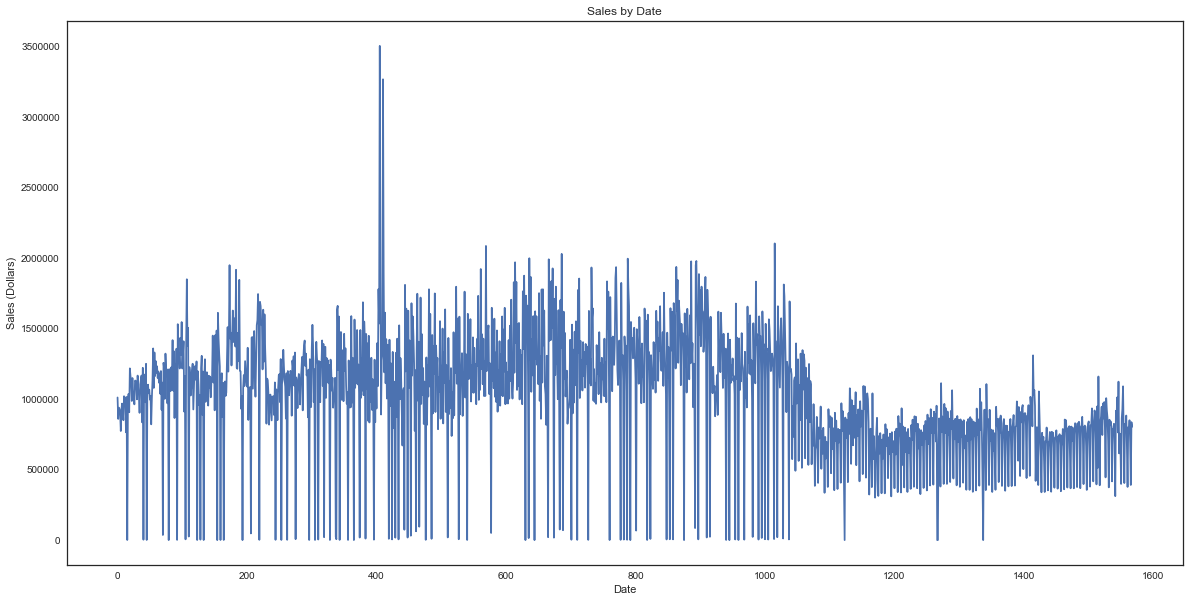

In [220]:
plt.figure(figsize=(20,10))
plt.plot(df_liquor['Sale (Dollars)'])
plt.title('Sales by Date')
plt.ylabel('Sales (Dollars)')
plt.xlabel('Date')
plt.show()

#### Sales over time
Daily sales of alcohol fluctuated over the 2401 day period around a mean of ~\$1million, with the 25% quartile at ~\$7.8 million and 75% quartile at ~\$1.2 million with significant spikes both to the upside and downside, resulting in an overall negative skew towards the downside. There is no visible overall trend in the time series but we do see one major spike towards the end of 2013.

We also see a reduction in major spikes since last year.

#### Pairplot
The pairplot() method of the seaborn package enables us to quickly visualise the relationships between pairs of variables. 

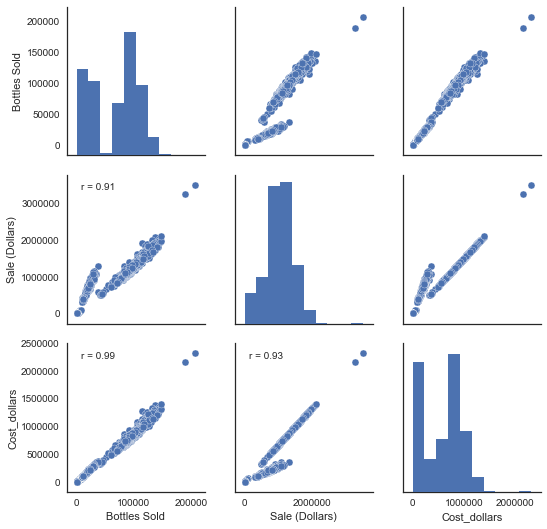

In [221]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
g = sns.pairplot(data=df_liquor)
g.map_lower(corrfunc)
plt.show()

The numeric values that we have a positive correlation.

#### Yearly sales breakdown

In [222]:
df_liquor.reset_index(inplace= True)
def quarter(x):
    if x<=3:
        return 1
    elif x<=6:
        return 2
    elif x<=9:
        return 3
    else:
        return 4
df_liquor['Year'] = df_liquor['Date'].apply(lambda x: x.year)
df_liquor['Month'] = df_liquor['Date'].apply(lambda x: x.month)
df_liquor['Quarter'] = df_liquor['Month'].apply(lambda x: quarter(x))

In [223]:
df_liquor.head()

,index,Date,Bottles Sold,Sale (Dollars),Cost_dollars,Year,Month,Quarter
0,0,2012-01-03,78227,1011220.92,673301.45,2012,1,1
1,1,2012-01-04,69453,859402.72,571951.08,2012,1,1
2,2,2012-01-05,77059,939144.34,625365.88,2012,1,1
3,3,2012-01-09,76862,929537.66,618868.92,2012,1,1
4,4,2012-01-10,71654,898232.47,598069.17,2012,1,1


In [224]:
table = pd.pivot_table(df_liquor, values='Sale (Dollars)', index=['Month'],columns=['Year'], aggfunc=np.sum)
table

Year,2012,2013,2014,2015,2016,2017,2018
Month,,,,,,,
1,1.588819e+07,1.781835e+07,20028552.41,18482931.21,18900960.48,13141647.89,14540748.02
2,1.809051e+07,1.823724e+07,19171249.84,21209105.87,21828270.65,12650678.99,12985699.18
3,1.811440e+07,1.820156e+07,19310967.91,23242637.60,22904517.70,14858724.34,14804024.91
4,1.997221e+07,2.213482e+07,22622423.70,22839904.30,21710932.33,13585940.88,14890776.48
5,2.216162e+07,2.238239e+07,20938711.93,22417179.56,24745115.52,16412250.26,17392858.19
6,2.182666e+07,1.971397e+07,24412684.26,27061734.10,25693070.95,16371156.68,16120571.81
7,2.066272e+07,2.260027e+07,21924940.32,22384829.04,20281344.42,14643874.77,15152294.65
8,2.149415e+07,2.152841e+07,21150099.56,22095886.09,22667257.81,16720926.29,NaN
9,1.816532e+07,1.910034e+07,23403995.96,24089347.59,14457878.11,13494825.14,NaN


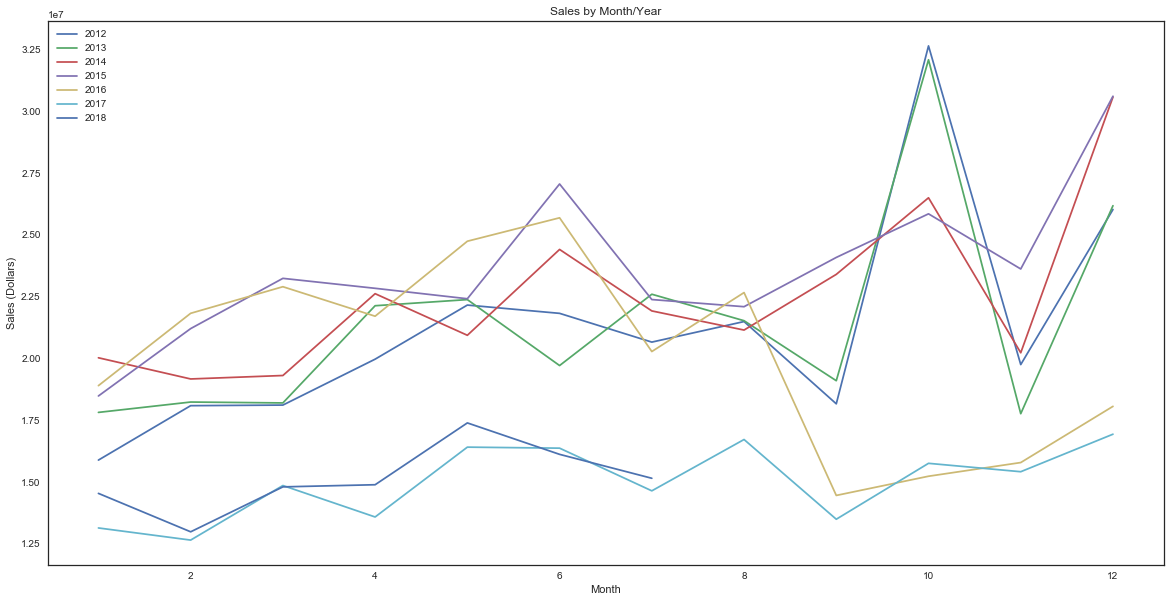

In [225]:
plt.figure(figsize=(20,10))
plt.plot(table)
plt.title('Sales by Month/Year')
plt.ylabel('Sales (Dollars)')
plt.xlabel('Month')
plt.legend(['2012','2013','2014','2015','2016','2017','2018'], loc='upper left')
plt.show()

**Observations**

1. For monthly aggregated data, we see that 2012 and 2013 October had the most sales.
2. 2014 seemed like a consistent year.
3. The sales always peak around new years. 
4. There has been a reduction in alcohol consumption over the year, as we can see from 2016, 2017 and half of 2018 data. 

### Linear Regression

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [226]:
from sklearn import linear_model
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score

#### Linear regression to predict yearly for Iowa

Let's divide our dataset into train and test.

In [266]:
# Creating dataset for test and train. 
# test dataset till 2016
df_train = df_liquor[pd.DatetimeIndex(df_liquor['Date']).year < 2016]
# train dataset till 2016
df_test = df_liquor[pd.DatetimeIndex(df_liquor['Date']).year > 2015]

In [267]:
df_train.drop('index', axis = 1, inplace= True)
df_train.set_index('Date', inplace=True)
df_train.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Bottles Sold,Sale (Dollars),Cost_dollars,Year,Month,Quarter
Date,,,,,,
2012-01-03,78227,1011220.92,673301.45,2012,1,1
2012-01-04,69453,859402.72,571951.08,2012,1,1
2012-01-05,77059,939144.34,625365.88,2012,1,1
2012-01-09,76862,929537.66,618868.92,2012,1,1
2012-01-10,71654,898232.47,598069.17,2012,1,1


In [268]:
df_train.head()

,Bottles Sold,Sale (Dollars),Cost_dollars,Year,Month,Quarter
Date,,,,,,
2012-01-03,78227,1011220.92,673301.45,2012,1,1
2012-01-04,69453,859402.72,571951.08,2012,1,1
2012-01-05,77059,939144.34,625365.88,2012,1,1
2012-01-09,76862,929537.66,618868.92,2012,1,1
2012-01-10,71654,898232.47,598069.17,2012,1,1


In [269]:
df_train.shape, df_train.shape

((916, 6), (916, 6))

In [270]:
X = df_train.drop('Sale (Dollars)', axis = 1)
lm = linear_model.LinearRegression(fit_intercept = True)

In [271]:
model = lm.fit(X, df_train['Sale (Dollars)'])
y_pred = model.predict(X)

print('Coefficient: '+ str(model.coef_))
print('Intercept: ' + str(model.intercept_))
print('MSE: '+ str(mean_squared_error(y_pred, y)))
print('R^2: '+ str(r2_score(y, y_pred)))

Coefficient: [-2.02104287e-01  1.52712232e+00 -7.63663166e+02 -1.10230609e+03
  3.38189375e+03]
Intercept: 1536215.2362982403
MSE: 3633373.331575679
R^2: 0.9999809164662609


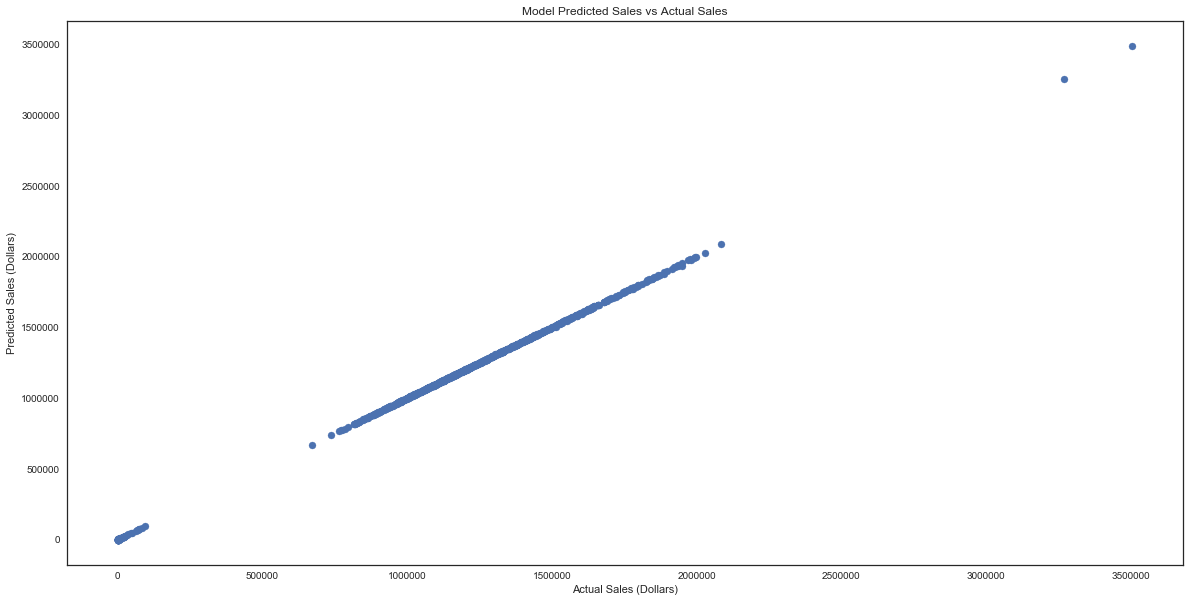

In [272]:
plt.figure(figsize=(20,10))
plt.scatter(df_train['Sale (Dollars)'], y_pred)
plt.title('Model Predicted Sales vs Actual Sales')
plt.xlabel('Actual Sales (Dollars)')
plt.ylabel('Predicted Sales (Dollars)')
plt.show()

The outliers make it difficult to visually assess the spread of points. Taking log on both x and y scales gives us:

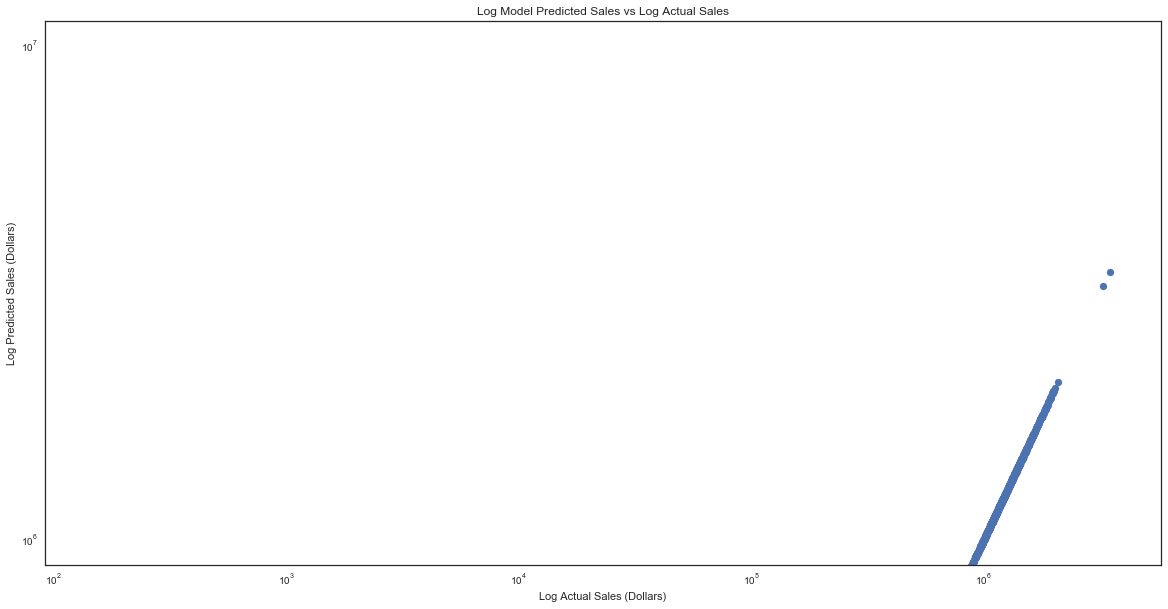

In [273]:
plt.figure(figsize=(20,10))
plt.scatter(df_train['Sale (Dollars)'], y_pred)
plt.title('Log Model Predicted Sales vs Log Actual Sales')
plt.xlabel('Log Actual Sales (Dollars)')
plt.ylabel('Log Predicted Sales (Dollars)')
plt.xscale('log')
plt.yscale('log')
plt.show()

This is in line with the high $R^2$ score calculated above.

Having trained the model on training data and validated it on 2015 total sales, we will now test its accuracy on test data.

In [274]:
df_test.drop('index', axis = 1, inplace= True)
df_test.set_index('Date', inplace=True)
df_test.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Bottles Sold,Sale (Dollars),Cost_dollars,Year,Month,Quarter
Date,,,,,,
2016-01-04,121118,1583927.94,1055361.64,2016,1,1
2016-01-05,90766,1167492.33,777905.10,2016,1,1
2016-01-06,94776,1207356.46,804436.51,2016,1,1
2016-01-07,81615,1042222.38,694425.05,2016,1,1
2016-01-11,96289,1229380.00,819215.48,2016,1,1


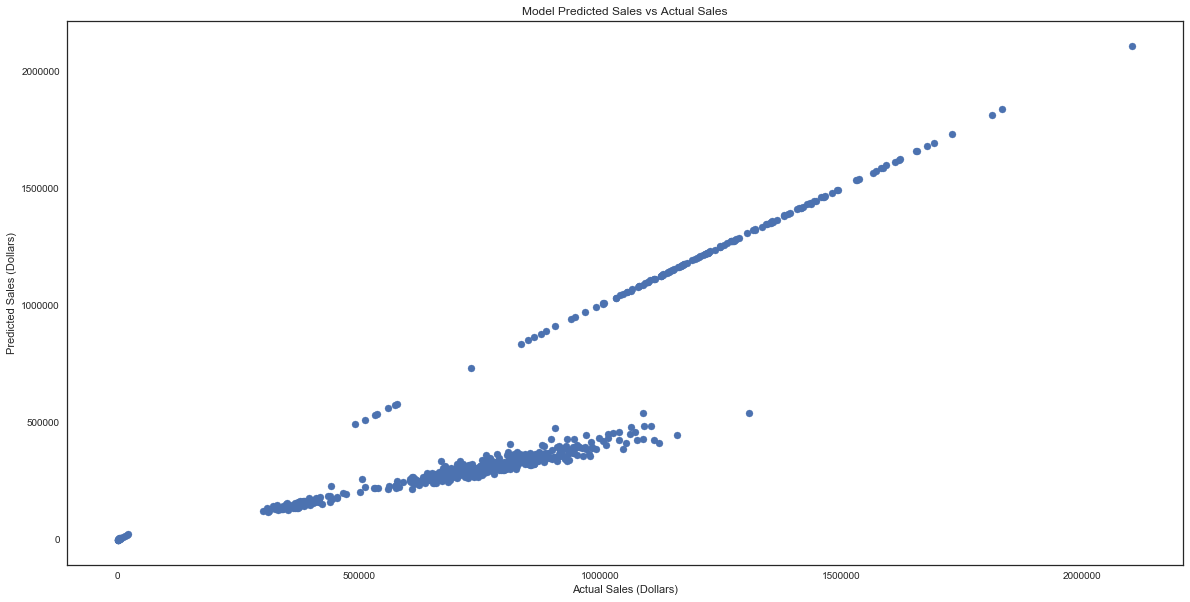

In [275]:
X_test = df_test.drop('Sale (Dollars)', axis = 1)
y_pred_test = model.predict(X_test)
#predicted_sales_2016 = y_pred.sum()

plt.figure(figsize=(20,10))
plt.scatter(df_test['Sale (Dollars)'], y_pred_test)
plt.title('Model Predicted Sales vs Actual Sales')
plt.xlabel('Actual Sales (Dollars)')
plt.ylabel('Predicted Sales (Dollars)')
plt.show()

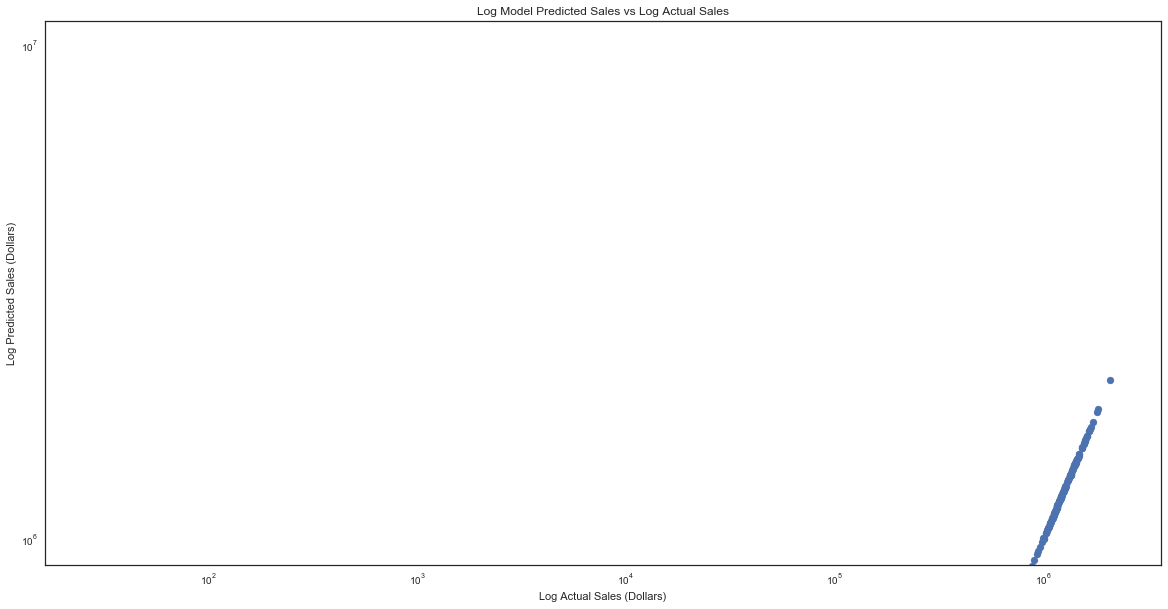

In [277]:
plt.figure(figsize=(20,10))
plt.scatter(df_test['Sale (Dollars)'], y_pred_test)
plt.title('Log Model Predicted Sales vs Log Actual Sales')
plt.xlabel('Log Actual Sales (Dollars)')
plt.ylabel('Log Predicted Sales (Dollars)')
plt.xscale('log')
plt.yscale('log')
plt.show()